## Install Required Libraries

---



---



In [ ]:
!pip install segmentation_models
!pip install dataframe_image

## Importing Required Dependencies




---



---



In [ ]:
import os 
import cv2
import tensorflow as tf
import keras.backend as K
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import segmentation_models as sm
import albumentations as aug
import dataframe_image as dfi

In [ ]:
train_dir = '/content/drive/MyDrive/Computer_Vision_Assignment/A2_Semantic_Segmentation/Dataset1/images_prepped_train'
train_mask_dir = '/content/drive/MyDrive/Computer_Vision_Assignment/A2_Semantic_Segmentation/Dataset1/annotations_prepped_train'
test_dir = '/content/drive/MyDrive/Computer_Vision_Assignment/A2_Semantic_Segmentation/Dataset1/images_prepped_test'
test_mask_dir = '/content/drive/MyDrive/Computer_Vision_Assignment/A2_Semantic_Segmentation/Dataset1/annotations_prepped_test'

## classes for data loading and preprocessing

---



---



In [ ]:
class Dataset:
    def __init__(
            self, 
            images_directory, 
            masks_dir,  
            augmentations = None, 
            preprocessing = None,
    ):
        self.ids = os.listdir(images_directory)
        self.images_fps = [os.path.join(images_directory, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values =[i for i in range(12)]
        self.augmentations = augmentations
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Augmentations
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

## Data Augmentation

---



---



In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [

        aug.HorizontalFlip(p=0.5),

        aug.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        aug.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        aug.RandomCrop(height=320, width=320, always_apply=True),

        aug.IAAAdditiveGaussianNoise(p=0.2),
        aug.IAAPerspective(p=0.5),

        aug.OneOf([
                aug.CLAHE(p=1),
                aug.RandomBrightness(p=1),
                aug.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        aug.OneOf([
                aug.IAASharpen(p=1),
                aug.Blur(blur_limit=3, p=1),
                aug.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        aug.OneOf([
                aug.RandomContrast(p=1),
                aug.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        aug.Lambda(mask = round_clip_0_1)
    ]
    return aug.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        aug.PadIfNeeded(320, 320)
    ]
    return aug.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        aug.Lambda(image = preprocessing_fn),
    ]
    return aug.Compose(_transform)

## Modelling

---



---



In [ ]:
SM_FRAMEWORK = tf.keras
sm.set_framework('tf.keras')

In [ ]:
# network parameters
BACKBONE = 'vgg16'
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 8
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 12
activations =  'softmax' 

model = sm.Unet(BACKBONE, input_shape=(320,320,3),
                classes = n_classes, activation = activations, 
                encoder_freeze=True)

58889256/58889256 [==============================] - 0s 0us/step


## Custom Metrics 

---



---



In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## Compiling the Model

---



---



In [ ]:
optim = tf.keras.optimizers.Adam(LR)
loss = sm.losses.categorical_focal_dice_loss 
metrics = [dice_coef,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy',sensitivity,specificity]
model.compile(optim, loss, metrics)

## Loading the Dataset

---



---



In [ ]:
train_dataset = Dataset(
    train_dir, 
    train_mask_dir, 
    augmentations = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocess_input),)

train_X, val_X = train_test_split(train_dataset, test_size = 0.2, random_state = 8) # 20% Validation set
train_dataloader = Dataloder(train_X, batch_size=BATCH_SIZE, shuffle=True)

valid_dataloader = Dataloder(val_X, batch_size = 1, shuffle=False)
file_path='/content/drive/MyDrive/Computer_Vision_Assignment/A2_Semantic_Segmentation/Results_vgg16/'

# CallBacks 
callbacks = [
    keras.callbacks.ModelCheckpoint(file_path+'vgg16_fine_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min',min_delta=0.001)]

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

## Training the Model

---



---



In [ ]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs = EPOCHS,
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


36/36 [==============================] - 30s 391ms/step - loss: 0.8765 - dice_coef: 0.2838 - iou_score: 0.0922 - f1-score: 0.1248 - accuracy: 0.3775 - sensitivity: 0.2618 - specificity: 0.9921 - val_loss: 0.9292 - val_dice_coef: 0.2742 - val_iou_score: 0.0879 - val_f1-score: 0.1115 - val_accuracy: 0.2999 - val_sensitivity: 0.2943 - val_specificity: 0.9809 - lr: 0.0010
Epoch 2/30
36/36 [==============================] - 11s 316ms/step - loss: 0.7907 - dice_coef: 0.4490 - iou_score: 0.1763 - f1-score: 0.2328 - accuracy: 0.4824 - sensitivity: 0.5056 - specificity: 0.9833 - val_loss: 0.9374 - val_dice_coef: 0.2546 - val_iou_score: 0.0944 - val_f1-score: 0.1201 - val_accuracy: 0.2454 - val_sensitivity: 0.2915 - val_specificity: 0.9393 - lr: 0.0010
Epoch 3/30
36/36 [==============================] - 12s 344ms/step - loss: 0.7535 - dice_coef: 0.4906 - iou_score: 0.2099 - f1-score: 0.2775 - accuracy: 0.5053 - sensitivity: 0.5654 - specificity: 0.9802 - val_loss: 0.8315 - val_dice_coef: 0.4286 

##Plotting Figures (Metrices)

---



---



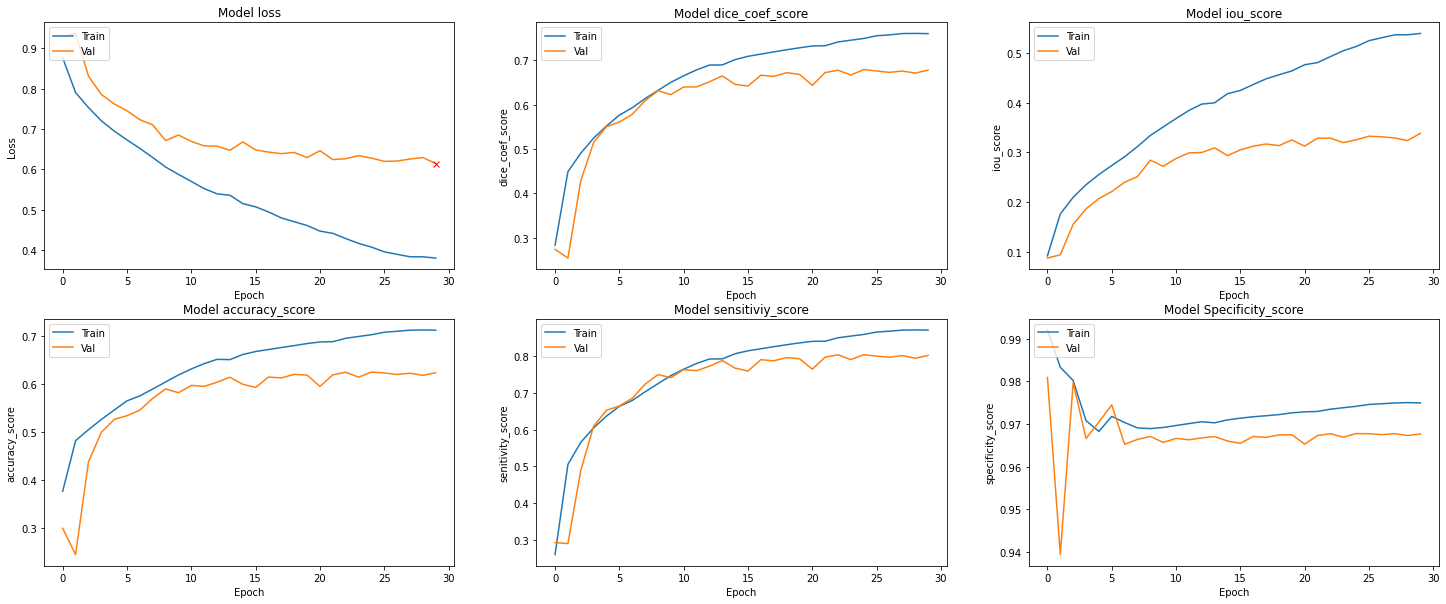

In [ ]:
plt.figure(figsize=(25, 10))

#Plot training & validation loss values

# Loss
plt.subplot(231)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(np.argmin(model.history.history['val_loss']), np.min(model.history.history['val_loss']), marker="x", color="r", label="best model")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Dice Coefficent
plt.subplot(232)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef_score')
plt.ylabel('dice_coef_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# IOU Score
plt.subplot(233)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Accuracy
plt.subplot(234)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy_score')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Sensitivity
plt.subplot(235)
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model sensitiviy_score')
plt.ylabel('senitivity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Specificity
plt.subplot(236)
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity_score')
plt.ylabel('specificity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(file_path+'aug_vgg16_trans_loss')
plt.show()

## Model Evaluation

---



---



In [ ]:
test_dataset = Dataset(
    test_dir, 
    test_mask_dir, 
    augmentations = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocess_input),
)
test_dataloader = Dataloder(test_dataset, 
                            batch_size = 1, 
                            shuffle = False)

In [ ]:
# load best weights
path_to_weights='/content/drive/MyDrive/Computer Vision Assignment/A2_Semantic_Segmentation/Results_vgg16/vgg16_fine_best_model.epoch30-loss0.61.hdf5'
model.load_weights(path_to_weights) 

In [ ]:
scores = model.evaluate_generator(test_dataloader)
s = pd.Series({'Model': 'VGG16 with Augmenatation', 
               'CFD-Loss': scores[0], 
               'dice-coeff': scores[1],
               'IOU score':scores[2],
               'F1-Score':scores[3],
               'Accuracy':scores[4],
               'Sensitivity':scores[5],
               'Specificity':scores[6]})
df=pd.DataFrame(s)
df_styled = df.style.background_gradient()
df.set_axis(['values'], axis=1, inplace=True)
dfi.export(df_styled, "aug-vgg16-freeze.png", table_conversion = "matplotlib")
df.head(8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


,values
Model,Densenet121 with Augmenatation
CFD-Loss,0.434438
dice-coeff,0.862913
IOU score,0.499845
F1-Score,0.589013
Accuracy,0.86716
Sensitivity,0.864796
Specificity,0.988597


## Visualization

---



---



In [ ]:
def visualize(sv,dest_path,model_name,**images):
    n = len(images)
    r=np.ceil(n/4)
    c=np.ceil(n/4)
    if (c==1.0):
      c=3
    plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(r, c, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if sv==1:
      plt.savefig(dest_path+model_name)
    plt.show()

def Visualize_overlay_mask(sv,dest_path,model_name,image,mask):

  fig,ax =plt.subplots()
  plt.xticks([])
  plt.yticks([])
  ax.imshow(image)
  ax.imshow(mask,alpha=0.5)
  plt.title(model_name.title())
  if sv == 1:
    plt.savefig(dest_path + model_name)
  plt.show()


def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

[ 20 100   2  35]
1/1 [==============================] - 0s 20ms/step


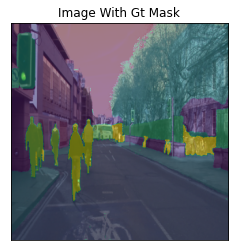

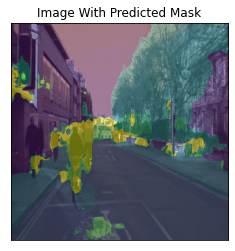

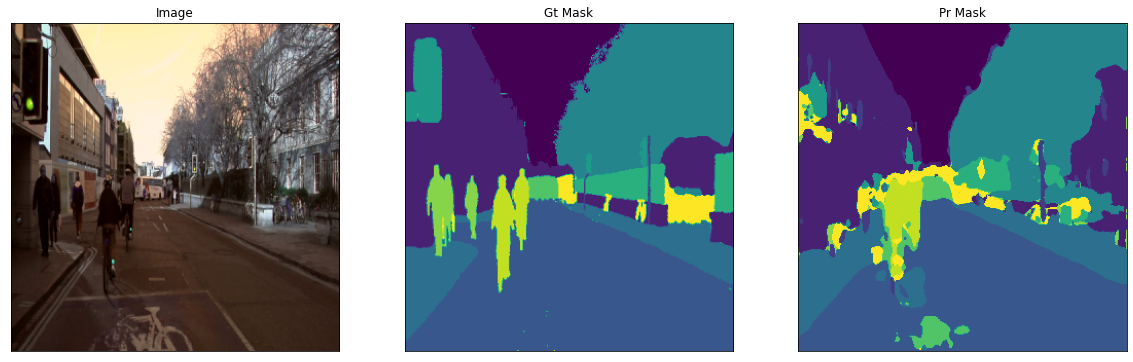

1/1 [==============================] - 0s 18ms/step


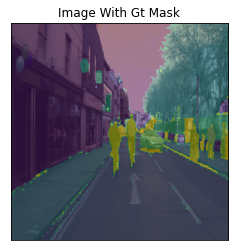

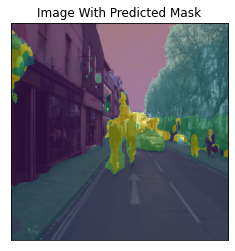

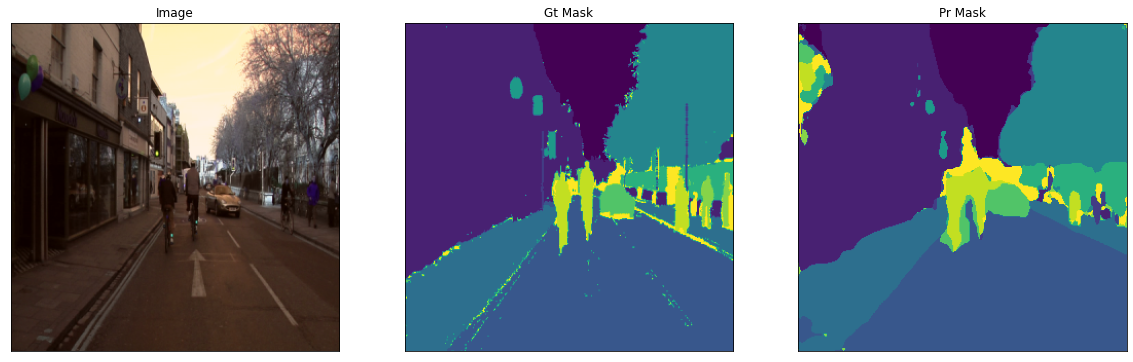

1/1 [==============================] - 0s 19ms/step


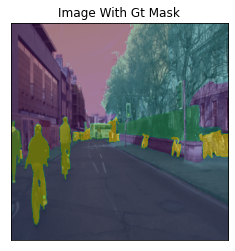

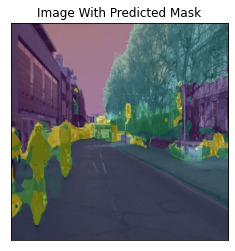

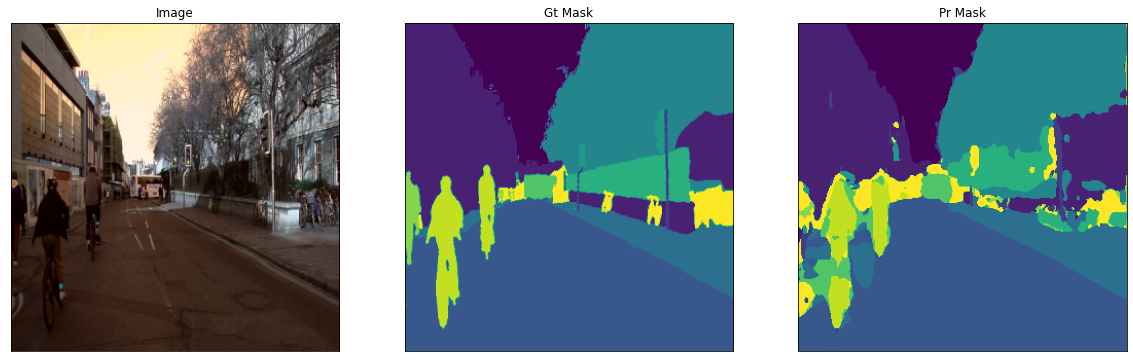

1/1 [==============================] - 0s 18ms/step


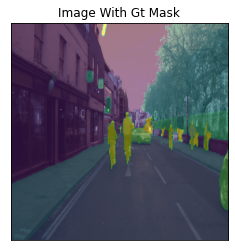

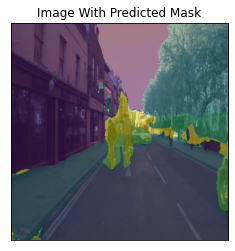

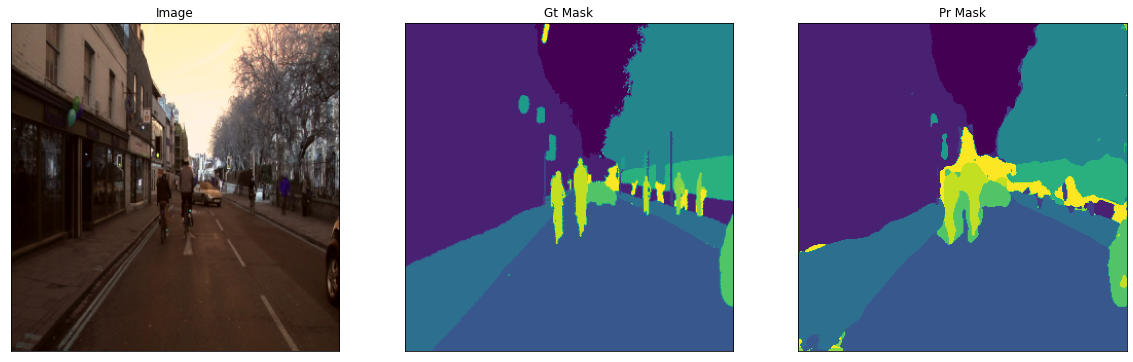

In [ ]:
n = 4
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
print(ids)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    Gt_mask=np.argmax(gt_mask.squeeze(),axis=-1)
    Pr_mask=np.argmax(pr_mask.squeeze(),axis=-1)
    Visualize_overlay_mask(1,file_path,'Image with GT mask',
      image=denormalize(image.squeeze()),
      mask = Gt_mask)
    Visualize_overlay_mask(1,file_path,'Image with predicted mask',
        image=denormalize(image.squeeze()),
        mask=Pr_mask)
    visualize(1,file_path,'VGG16-CFD',
        image=denormalize(image.squeeze()),
        GT_mask=Gt_mask,
        Pr_mask=Pr_mask)